# Rozpoznanie czerniaka na obrazku za pomocą prostej sieci konwolucyjnej

Zaczynamy od wstępnego przetwarzania danych danych treningowych i testowych za pomocą klasy `ImageDataGenerator`.
Za jej pomocą osiągamy kilku celów:
- zwiększamy ilość danych testowych, ponieważ `ImageDataGenerator` tworzy nowe obrazy ze starych, stosując transformacji (skalowanie, horyzontalne obracanie, itd).
- formatowanie obrazów do konwolucji

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('training_galery',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 4000 images belonging to 2 classes.


In [3]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('testing_galery',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1000 images belonging to 2 classes.


Budujemy sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

Tworzymy strategiję obliczeniową.

In [5]:
cnn = Sequential([
    # pierwsza warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D(pool_size=2, strides=2),

    # druga warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # trzecia warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # wyprostowanie
    Flatten(),

    # 2 warstwy gęste
    Dense(units=128, activation='relu'),
    Dense(units=128, activation='relu'),

    # warstwa wyjściowa
    Dense(units=1, activation='sigmoid')
])

Kompilujemy poprzednio zbudowany model.

In [6]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Trenujemy sieć konwolucyjną.

In [7]:
history = cnn.fit(x=training_set, validation_data=test_set, epochs=25)

Epoch 1/25
125/125 [==============================] - 215s 2s/step - loss: 0.3351 - accuracy: 0.8469 - val_loss: 0.0496 - val_accuracy: 0.9880
Epoch 2/25
125/125 [==============================] - 212s 2s/step - loss: 0.0739 - accuracy: 0.9780 - val_loss: 0.0333 - val_accuracy: 0.9910
Epoch 3/25
125/125 [==============================] - 212s 2s/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.1104 - val_accuracy: 0.9710
Epoch 4/25
125/125 [==============================] - 212s 2s/step - loss: 0.0728 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9850
Epoch 5/25
125/125 [==============================] - 212s 2s/step - loss: 0.0601 - accuracy: 0.9849 - val_loss: 0.0329 - val_accuracy: 0.9910
Epoch 6/25
125/125 [==============================] - 212s 2s/step - loss: 0.0453 - accuracy: 0.9887 - val_loss: 0.0223 - val_accuracy: 0.9930
Epoch 7/25
125/125 [==============================] - 212s 2s/step - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.0208 - val_accuracy: 0.9930

Historia trenowania modelu.

In [8]:
import matplotlib.pyplot as plt

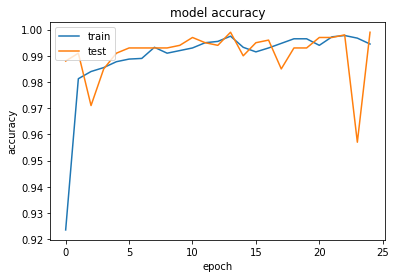

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

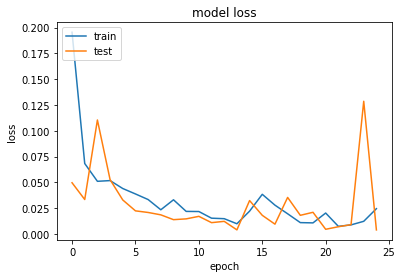

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Zapisujemy model.

In [11]:
cnn_json_structure = cnn.to_json()
with open("simple_cnn.json", "w") as json_file:
    json_file.write(cnn_json_structure)
cnn.save_weights("simple_cnn.h5")

Ładujemy model, żeby sprawdzić czy poprawnie zapisaliśmy go.

In [29]:
from tensorflow.keras.models import model_from_json

In [30]:
json_file = open('simple_cnn.json', 'r')
cnn_json_structure = json_file.read()
json_file.close()
cnn = model_from_json(cnn_json_structure)
cnn.load_weights("simple_cnn.h5")

Robimy kilka testowych pojedynczych.
1) dla prawdziwej melanomy (obazek z ISIC, który nie był wykorzystywany przy nauczeniu się).

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [32]:
test_image = image.load_img('single_prediction_galery/ISIC_0010000.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image *= (1/255.0)
result = cnn.predict(test_image)

In [33]:
training_set.class_indices

{'melanoma': 0, 'other': 1}

In [34]:
result

array([[0.00019999]], dtype=float32)

2) dla ospy wietrznej (może być podobna)

In [35]:
test_image = image.load_img('single_prediction_galery/ospa.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image *= (1/255.0)
result = cnn.predict(test_image)

In [36]:
result

array([[0.00013552]], dtype=float32)

3) dla kota (to co nie ma nijakiego związku)

In [39]:
test_image = image.load_img('single_prediction_galery/kotek.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image *= (1/255.0)
result = cnn.predict(test_image)

In [40]:
result

array([[0.9999988]], dtype=float32)